In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import tensorflow as tf

In [3]:
from vaneska.models import Gaussian
from vaneska.photometry import PSFPhotometry

In [4]:
from tqdm import tqdm

In [5]:
from lightkurve import KeplerTargetPixelFile, LightCurve

In [6]:
tpf = KeplerTargetPixelFile.from_archive('kepler-10b', quarter=5)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2010174085026_lpd-targ.fits.gz with expected size 4685387. [astroquery.query]


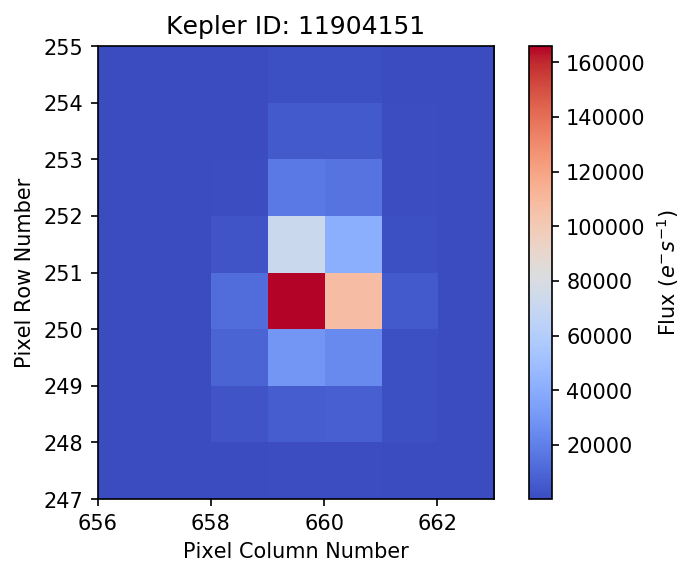

In [7]:
tpf.plot(scale=None, bkg=True, cmap='coolwarm')

In [8]:
gaussian = Gaussian(shape=tpf.shape[1:], col_ref=tpf.column, row_ref=tpf.row)

In [9]:
xc, yc = tpf.centroids()

In [10]:
fluxes = [tf.Variable(initial_value=np.nansum(tpf.flux, axis=(1, 2))[i], dtype=tf.float64)
          for i in range(10)]
cols = [tf.Variable(initial_value=xc[i], dtype=tf.float64,)
        for i in range(10)]
rows = [tf.Variable(initial_value=yc[i], dtype=tf.float64,)
        for i in range(10)]
a = [tf.Variable(initial_value=np.ones(tpf.shape[0])[i], dtype=tf.float64)
     for i in range(10)]
b = [tf.Variable(initial_value=np.zeros(tpf.shape[0])[i], dtype=tf.float64)
     for i in range(10)]
c = [tf.Variable(initial_value=np.ones(tpf.shape[0])[i], dtype=tf.float64)
     for i in range(10)]
bkg = [tf.Variable(initial_value=np.nanmean(tpf.flux_bkg, axis=(1, 2))[i], dtype=tf.float64)
       for i in range(10)]

In [11]:
mean = [gaussian(fluxes[i], cols[i], rows[i], a[i], b[i], c[i]) + bkg[i] for i in tqdm(range(10))]

100%|██████████| 10/10 [00:00<00:00, 26.05it/s]


In [12]:
flat_field = tf.Variable(initial_value=np.ones_like(tpf.flux[0]), dtype=tf.float64)

In [13]:
data = tf.placeholder(dtype=tf.float64)

In [25]:
# Poisson likelihood
loss = tf.reduce_sum(tf.subtract(tf.multiply(mean, flat_field),
                                 tf.multiply(data, tf.log(mean) + tf.log(flat_field)))) 

In [26]:
var_list=[flat_field] + sum([fluxes, cols, rows, a, b, c, bkg], [])

In [27]:
grad = tf.gradients(loss, var_list)

In [28]:
session = tf.Session()
session.run(fetches=tf.global_variables_initializer())

In [29]:
session.run(grad, feed_dict={data: tpf.flux[1000:1010] + tpf.flux_bkg[1000:1010]})

[array([[ -1.19379993e+03,  -1.70239009e+03,  -4.22161064e+03,
          -6.92042266e+03,  -8.45022322e+03,  -3.09728286e+03,
          -5.57089828e+02],
        [ -1.81355030e+03,  -4.43056077e+03,  -3.43508257e+04,
          -6.45183490e+04,  -6.36621023e+04,  -1.42989545e+04,
          -7.06736806e+02],
        [ -5.48849340e+02,  -2.90962867e+03,  -8.75079700e+04,
          -2.03526939e+05,  -1.40737604e+05,   8.19767634e+03,
          -4.04433031e+02],
        [ -9.79498755e+02,  -4.92538305e+03,  -9.95092675e+04,
          -1.14006634e+06,  -1.56022980e+04,   2.18946148e+05,
           4.69192254e+03],
        [ -7.11971046e+02,  -2.06488982e+03,   1.62962474e+04,
          -4.30060941e+04,   1.15866607e+06,   4.21409763e+05,
           1.40905390e+04],
        [ -3.59105283e+02,  -1.46263872e+03,  -4.86372245e+02,
          -1.60342247e+04,   1.98399939e+05,   8.47232696e+04,
           2.15064458e+03],
        [ -4.61392735e+02,  -6.74978446e+02,  -5.31768694e+03,
          -5.

In [30]:
session.run(loss, feed_dict={data: tpf.flux[1000:1010] + tpf.flux_bkg[1000:1010]})

-51918859.753296755

In [31]:
#session.run(grad, feed_dict={data: tpf.flux[1000:1010] + tpf.flux_bkg[1000:1010]})

In [32]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=loss, var_list=var_list, method='TNC')

In [33]:
psf_flux = []

In [34]:
for i in tqdm(range((tpf.shape[0] - 10) // 10)):
    optimizer.minimize(session=session, feed_dict={data: tpf.flux[i*10:(i+1)*10] + tpf.flux_bkg[i*10:(i+1)*10]})
    psf_flux.append(session.run([fluxes]))

  0%|          | 0/448 [00:00<?, ?it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -54939070.813355
  Number of iterations: 5
  Number of functions evaluations: 108


  0%|          | 1/448 [00:02<20:16,  2.72s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|f_n-f_(n-1)| ~= 0)
  Objective function value: -55099075.478888
  Number of iterations: 41
  Number of functions evaluations: 306


  0%|          | 2/448 [00:04<16:23,  2.20s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55110364.839870
  Number of iterations: 16
  Number of functions evaluations: 101


  1%|          | 3/448 [00:04<12:18,  1.66s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55124020.440237
  Number of iterations: 15
  Number of functions evaluations: 114


  1%|          | 4/448 [00:05<10:25,  1.41s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55131803.414266
  Number of iterations: 17
  Number of functions evaluations: 112


  1%|          | 5/448 [00:06<09:20,  1.27s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55142491.878588
  Number of iterations: 14
  Number of functions evaluations: 87


  1%|▏         | 6/448 [00:06<08:29,  1.15s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55135657.505272
  Number of iterations: 21
  Number of functions evaluations: 163


  2%|▏         | 7/448 [00:07<08:17,  1.13s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55142257.401049
  Number of iterations: 18
  Number of functions evaluations: 161


  2%|▏         | 8/448 [00:08<08:06,  1.11s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: -55151075.451147
  Number of iterations: 21
  Number of functions evaluations: 215


  2%|▏         | 9/448 [00:10<08:13,  1.12s/it]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: -55150271.369170
  Number of iterations: 23
  Number of functions evaluations: 198


  2%|▏         | 10/448 [00:11<08:18,  1.14s/it]

KeyboardInterrupt: 

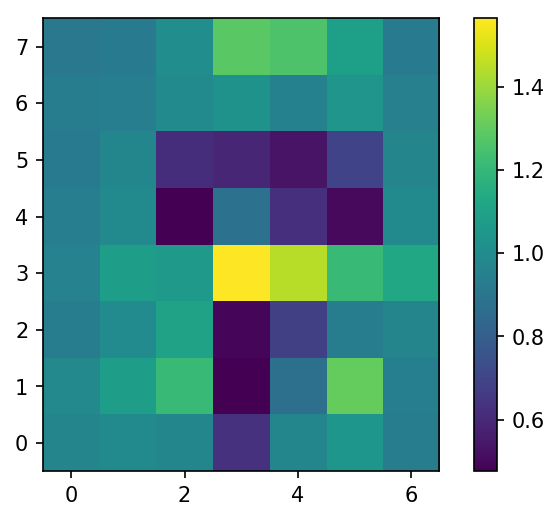

In [37]:
plt.imshow(session.run(flat_field), origin='lower')
plt.colorbar()

In [35]:
psf_flux = np.asarray(psf_flux)

In [36]:
psf_flux = psf_flux.reshape(-1)

In [77]:
psf_lc = LightCurve(tpf.time[:len(psf_flux)], psf_flux).flatten().fold(0.837495)

In [78]:
aper_lc = LightCurve(tpf.time, np.nansum(tpf.flux, axis=(1, 2))).flatten().fold(0.837495)

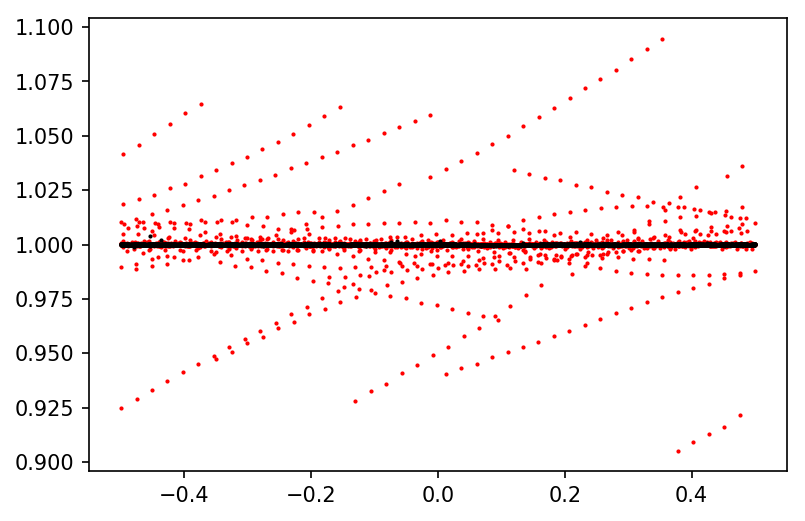

In [79]:
plt.plot(psf_lc.time, psf_lc.flux, 'ro', markersize=1)
plt.plot(aper_lc.time, aper_lc.flux, 'ko', markersize=1)

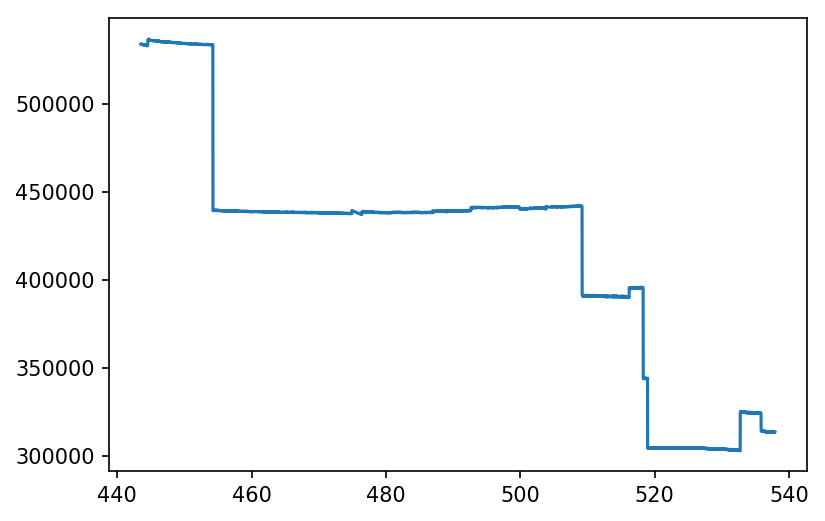

In [80]:
plt.plot(tpf.time[:len(psf_flux)], psf_flux)

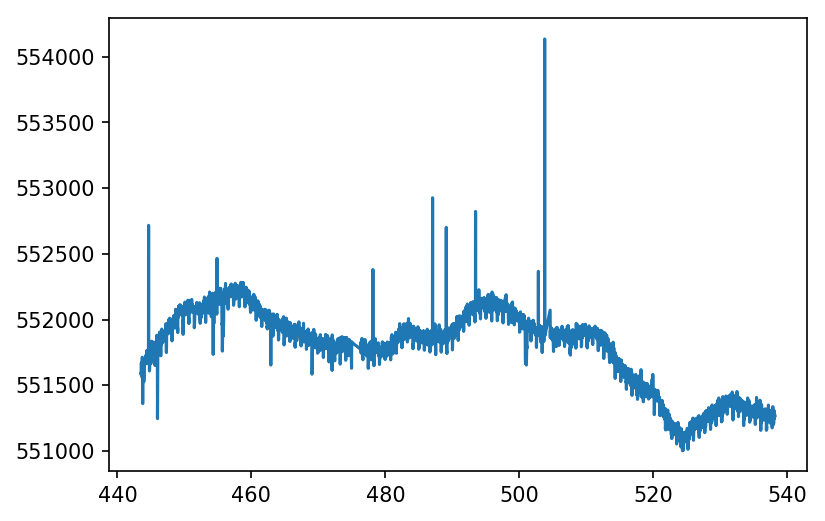

In [47]:
plt.plot(tpf.time, np.nansum(tpf.flux, axis=(1, 2)))